In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

In [2]:
uniref90_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_binary.csv")
uniref90_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_multi.csv")
uniprot_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_binary.csv")
uniprot_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")

In [3]:
spike_protein_domain_map = {
    "NTD": [14, 305],
    "S1": [14, 685],
#    "S2 Subunit": [686, 1273],
    "RBD": [319, 541],
#    "RBM": [438, 506],
#     "FP": [788, 806],
#     "HR1": [912, 984],
#     "HR2": [1163, 1213]
}


experiment_rename_map = {
    "sarscov2-uniref90-aligned-binary": "UniRef90-Binary",
    "sarscov2-uniref90-aligned-multi": "UniRef90-Multi",
    "sarscov2-uniprot-aligned-binary": "UniProt-Binary",
    "sarscov2-uniprot-aligned-multi": "UniProt-Multi",
}

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"

def annotate_region(pos, region):
    pos = int(pos)
    start = spike_protein_domain_map[region][0]
    end = spike_protein_domain_map[region][1]
    if (int(pos) >= start and int(pos) <= end):
        return 1
    else:
        return None

In [4]:
file_paths = [uniref90_aligned_binary_file_path, uniref90_aligned_multi_file_path, uniprot_aligned_binary_file_path, uniprot_aligned_multi_file_path]
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.rename(columns={"uniref90_id": "id", "uniprot_id": "id"}, inplace=True)
    dfs.append(df[["id", human_label, "y_true", "orig_token", "perturb_seq_pos", "new_token", pred_diff_col, f"abs_{pred_diff_col}", "perturb_pos", "experiment"]])
df = pd.concat(dfs)
df = df[~df["perturb_seq_pos"].isna()]
df.shape

(19838, 10)

In [5]:
df["perturb_seq_pos"] = df["perturb_seq_pos"].astype("Int64")
df["perturbation_id"] = df.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
df.replace({"experiment": experiment_rename_map}, inplace=True)
df.columns

Index(['id', 'Human', 'y_true', 'orig_token', 'perturb_seq_pos', 'new_token',
       'Human_pred_diff', 'abs_Human_pred_diff', 'perturb_pos', 'experiment',
       'perturbation_id'],
      dtype='object')

In [6]:
df.head()

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,experiment,perturbation_id
0,UniRef90_A0A8B6RAI1,0.590175,Human,I,402,L,-0.397972,0.397972,1069,UniRef90-Binary,402_L
1,UniRef90_A0A8B6RAI1,0.571952,Human,V,401,L,-0.416195,0.416195,1068,UniRef90-Binary,401_L
2,UniRef90_A0A8B6RAI1,0.863793,Human,Q,409,L,-0.124355,0.124355,1076,UniRef90-Binary,409_L
3,UniRef90_A0A8B6RAI1,0.741563,Human,R,403,L,-0.246585,0.246585,1070,UniRef90-Binary,403_L
4,UniRef90_A0A8B6RJG7,0.852662,Human,Q,409,L,-0.135195,0.135195,1076,UniRef90-Binary,409_L


In [7]:
positions = df["perturb_seq_pos"].sort_values().unique()
print(positions)
len(positions)

<IntegerArray>
[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
 ...
 516, 517, 533, 575, 583, 584, 586, 596, 597, 598]
Length: 206, dtype: Int64


206

In [8]:
experiment_counts = df["experiment"].value_counts().to_dict()
experiment_counts

{'UniProt-Multi': 15637,
 'UniRef90-Multi': 3139,
 'UniProt-Binary': 761,
 'UniRef90-Binary': 301}

In [9]:
df_1 = df[["id", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"]).count()
df_1 = df_1.reset_index()
df_1["proportion"] = df_1.apply(lambda x: x["id"]/experiment_counts[x["experiment"]], axis=1)
 
df_1_pivot = df_1.pivot(columns="experiment", index="perturb_seq_pos", values="proportion")
df_1_pivot

experiment,UniProt-Binary,UniProt-Multi,UniRef90-Binary,UniRef90-Multi
perturb_seq_pos,,,,
1,NaN,NaN,NaN,0.000319
2,NaN,NaN,NaN,0.005734
3,NaN,NaN,NaN,0.007646
4,NaN,NaN,NaN,0.019433
5,NaN,NaN,NaN,0.016247
...,...,...,...,...
584,NaN,0.016116,NaN,NaN
586,NaN,0.013046,NaN,NaN
596,NaN,0.022255,NaN,NaN


In [10]:
# df_2 = df[["Human_pred_diff", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"])["Human_pred_diff"].agg(Max = "max", Mean = "mean")
# df_2 = df_2.reset_index()
# df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
# df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [11]:
df_2_all = df[["Human_pred_diff", "perturb_seq_pos"]].groupby(["perturb_seq_pos"])["Human_pred_diff"].agg(Min = "min", Mean = "mean", Max = "mean")
df_2_all = df_2_all.reset_index()
df_2_all = df_2_all.set_index("perturb_seq_pos")

In [12]:
vmin = df_2_all["Min"].min()
vmax = df_2_all["Max"].max()

In [13]:
#df_2_all[df_2_all["perturb_seq_pos"]==142]

In [14]:
df_2 = df[["Human_pred_diff", "perturb_seq_pos", "experiment"]].groupby(["experiment", "perturb_seq_pos"])["Human_pred_diff"].agg(Min = "min", Mean = "mean", Max = "mean")
df_2 = df_2.reset_index()
df_2 = df_2.set_index("perturb_seq_pos")
#df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
#df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [15]:
#df_2[df_2["perturb_seq_pos"]==128]

In [16]:
df_2.head(50).sort_values("perturb_seq_pos")

,experiment,Min,Mean,Max
perturb_seq_pos,,,,
105,UniProt-Multi,-0.106662,-0.106662,-0.106662
106,UniProt-Multi,-0.236587,-0.053089,-0.053089
107,UniProt-Multi,0.100036,0.103953,0.103953
109,UniProt-Multi,-0.116809,-0.103346,-0.103346
211,UniProt-Multi,-0.153767,-0.130278,-0.130278
240,UniProt-Multi,-0.161167,-0.121047,-0.121047
241,UniProt-Multi,-0.101646,0.055218,0.055218
242,UniProt-Multi,0.104538,0.105676,0.105676
248,UniProt-Multi,0.120024,0.120024,0.120024


In [17]:
n = df.shape[0]
df_3 = df["perturb_seq_pos"].value_counts().reset_index()
df_3.rename(columns={"index": "seq_pos", "perturb_seq_pos": "count"}, inplace=True)
df_3 = df_3.sort_values("seq_pos")
for k in list(spike_protein_domain_map.keys()):
   df_3[k] = df_3.apply(lambda x: annotate_region(x["seq_pos"], k), axis=1)
# #df_3 = df_3[list(spike_protein_domain_map.keys()]
# #df_3["RBD"] = df_3.apply(lambda x: annotate_region(x["perturb_seq_pos"], "RBD"), axis=1)

# for k in list(spike_protein_domain_map.keys()):
#    df_3[k] = df_3.apply(lambda x: x["count"]/n, axis=1)
df_3 = df_3.drop(columns="count").set_index("seq_pos")

In [ ]:
output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/visualization/prelim_exam/sarscov2_s_uniref90_uniprot_aligned_perturbation_analysis_vertical.pdf")
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})
fig, ax =plt.subplots(1,3,figsize=(10, 48), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
sns.heatmap(df_3, linewidth=.5, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=False)
ax[0].set_xlabel("Region")
ax[0].set_ylabel("Amino acid position")
sns.heatmap(df_1_pivot, linewidth=.5, ax=ax[1], cmap=sns.cm.rocket_r)
ax[1].set_xlabel("Experiment")
ax[1].set_ylabel("")
sns.heatmap(df_2, linewidth=.5, ax=ax[2], cmap=cmap, center=0)
ax[2].set_xlabel("Prediction Diff")
ax[2].set_ylabel("")
# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(wspace=.8)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.savefig(output_file_path)
plt.show()

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


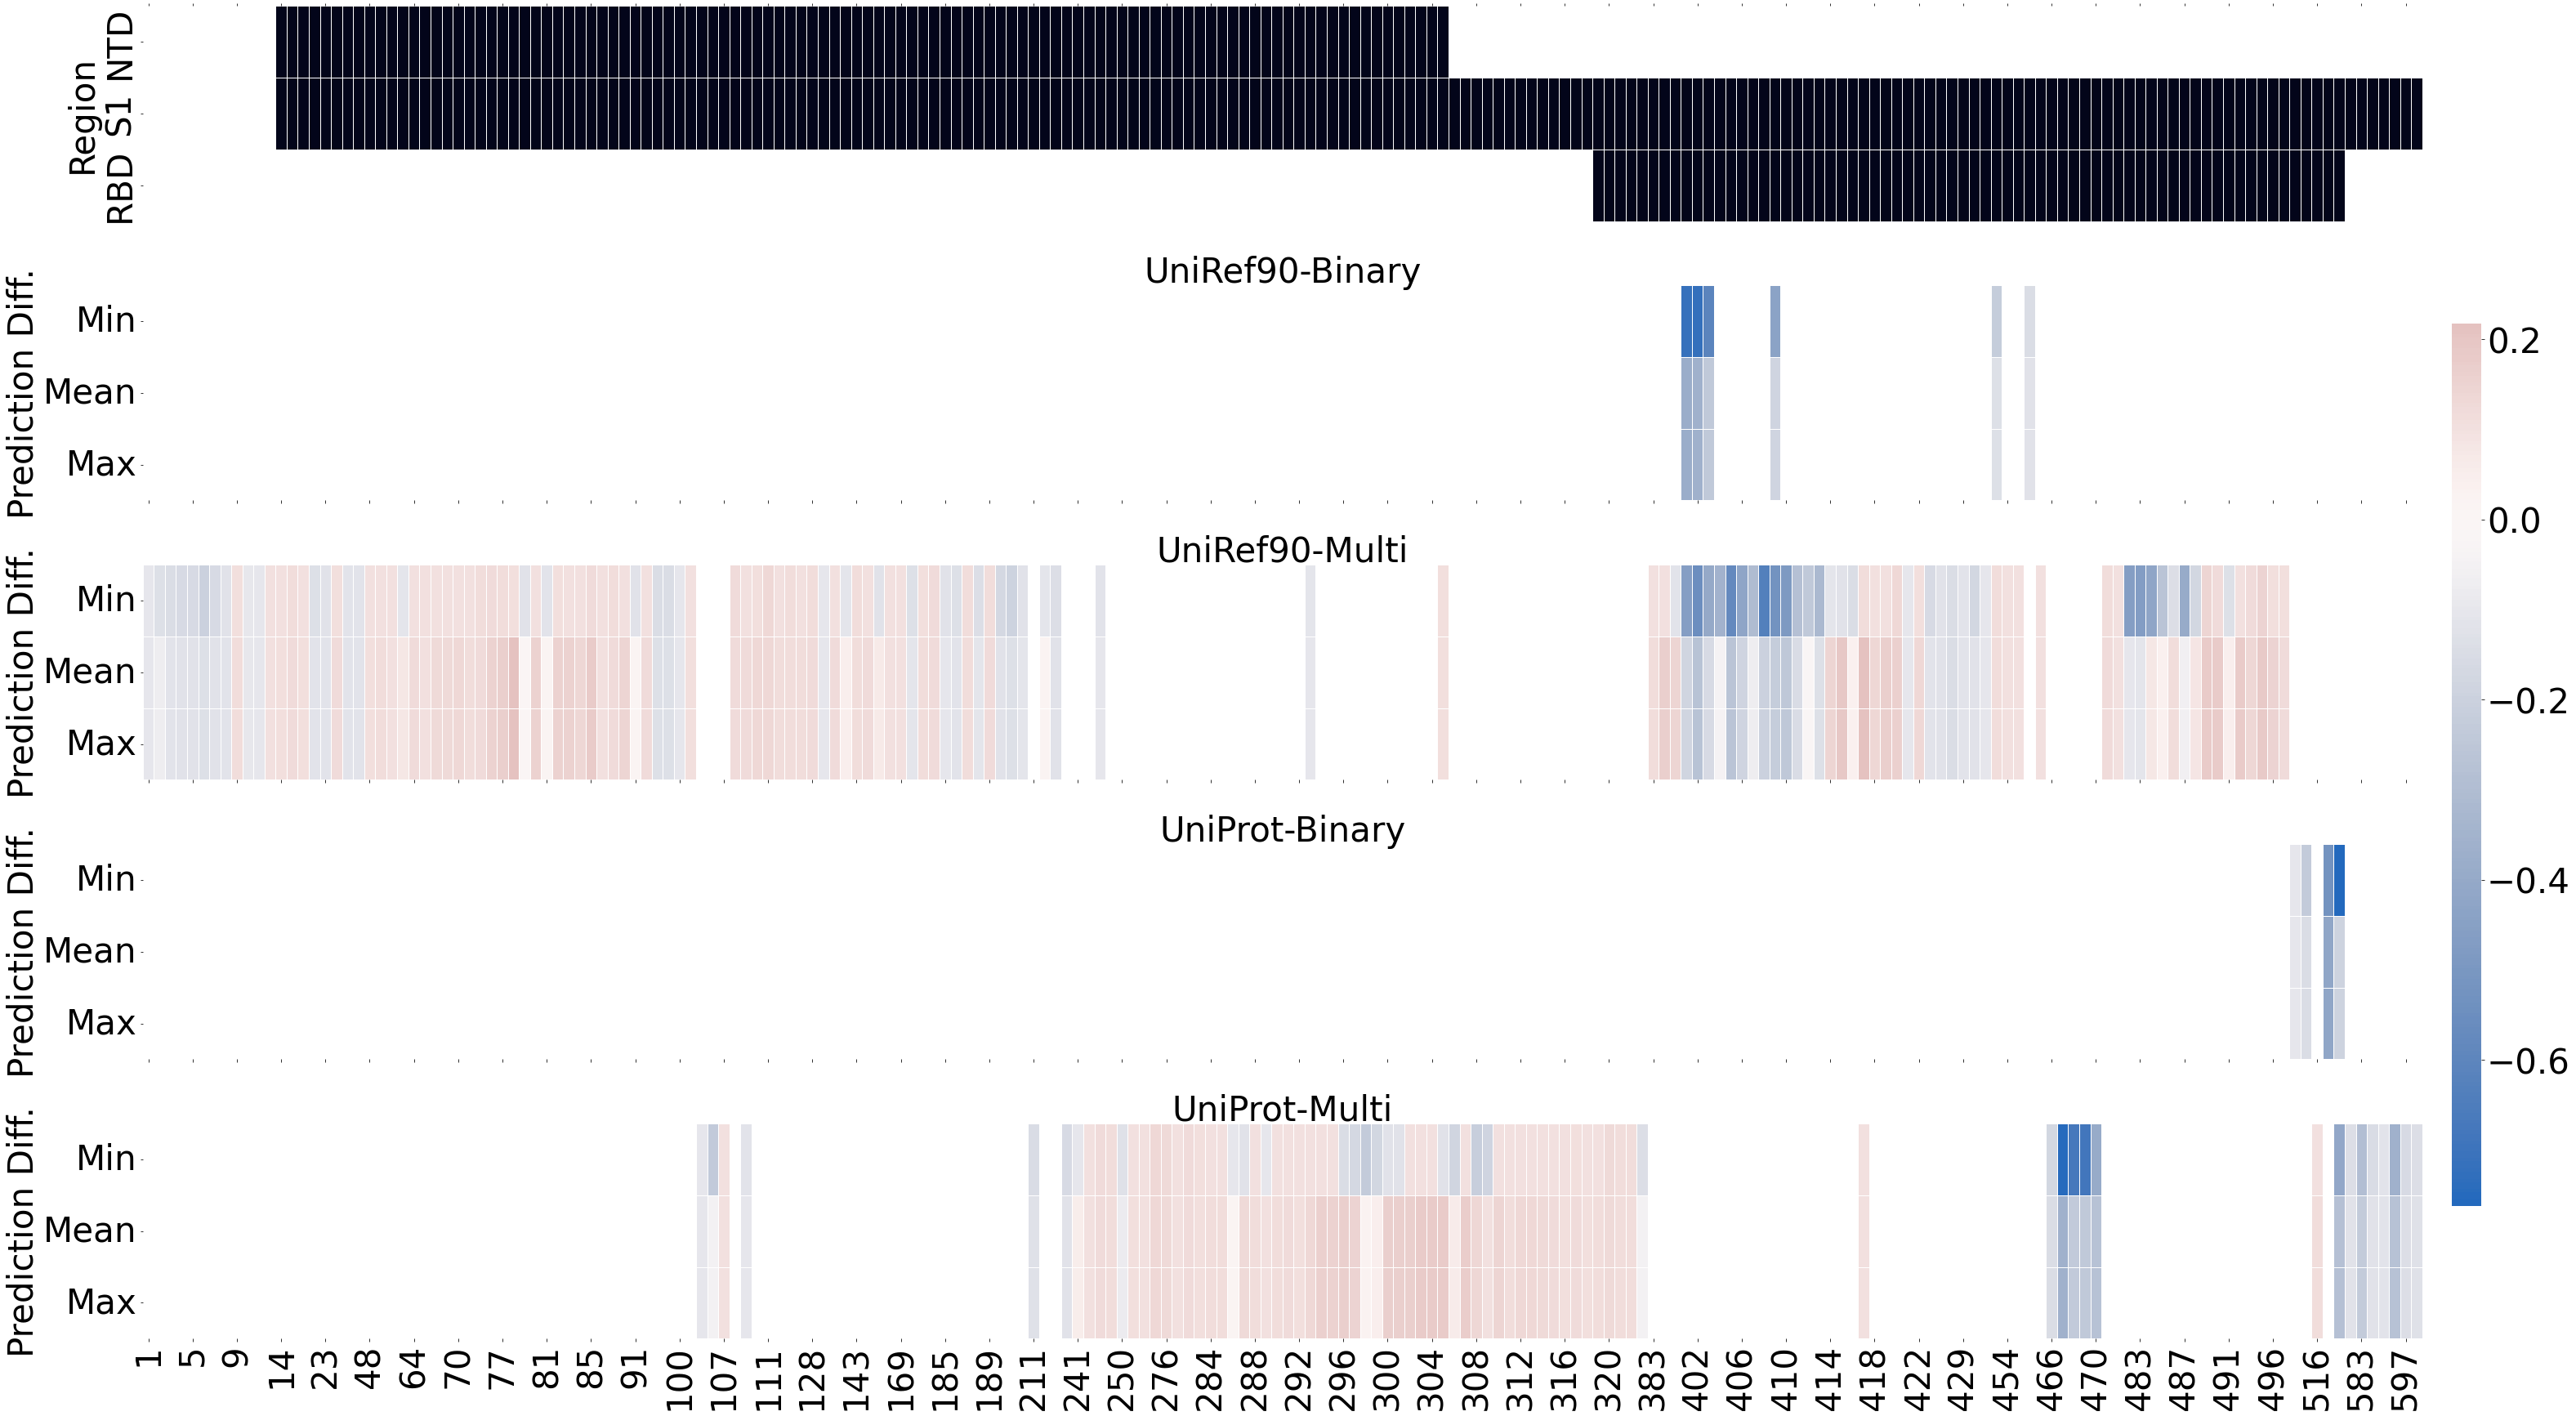

In [19]:
output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/visualization/prelim_exam/sarscov2_s_uniref90_uniprot_aligned_perturbation_analysis_horizontal.pdf")
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 42
plt.rcParams['ytick.labelsize'] = 42
plt.rcParams.update({'font.size': 42})
fig, ax =plt.subplots(5,1,figsize=(50, 30), sharex=True)#, gridspec_kw={'height_ratios': [.5, 1, 1, 1, 1]})

cbar_ax = fig.add_axes([.91, .2, .01, .5])

sns.heatmap(df_3.T, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=False, linewidth=.5)
ax[0].set_ylabel("Region", fontsize=42)
ax[0].set_xlabel("", fontsize=42)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position("top")

for i, val in enumerate(experiment_rename_map.values()):
    df_val = df_2[df_2["experiment"] == val]
    df_val.drop(columns=["experiment"], inplace=True)
    df_val = df_val.T
    df_val = df_val.reindex(columns=positions)
    sns.heatmap(df_val, linewidth=.5, ax=ax[i+1], cmap="vlag", center=0, vmin=vmin, vmax=vmax,
               cbar= i == 0,
               cbar_ax=None if i else cbar_ax)
    ax[i+1].set_ylabel("Prediction Diff.")
    ax[i+1].set_xlabel(val, fontsize=42)
    ax[i+1].xaxis.set_label_position("top")

# sns.heatmap(df_2_all.T, linewidth=.5, ax=ax[5], cmap="vlag", center=0)
# ax[5].set_ylabel("Prediction Diff.")
# ax[5].set_xlabel("All Models")
# ax[5].xaxis.set_label_position("top")


# sns.heatmap(df_1_pivot.T, linewidth=.5, ax=ax[5], cmap="rocket_r")
# ax[5].set_ylabel("", fontsize=32)
# ax[5].set_xlabel("")

# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(hspace=.3)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.savefig(output_file_path)
plt.show()

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


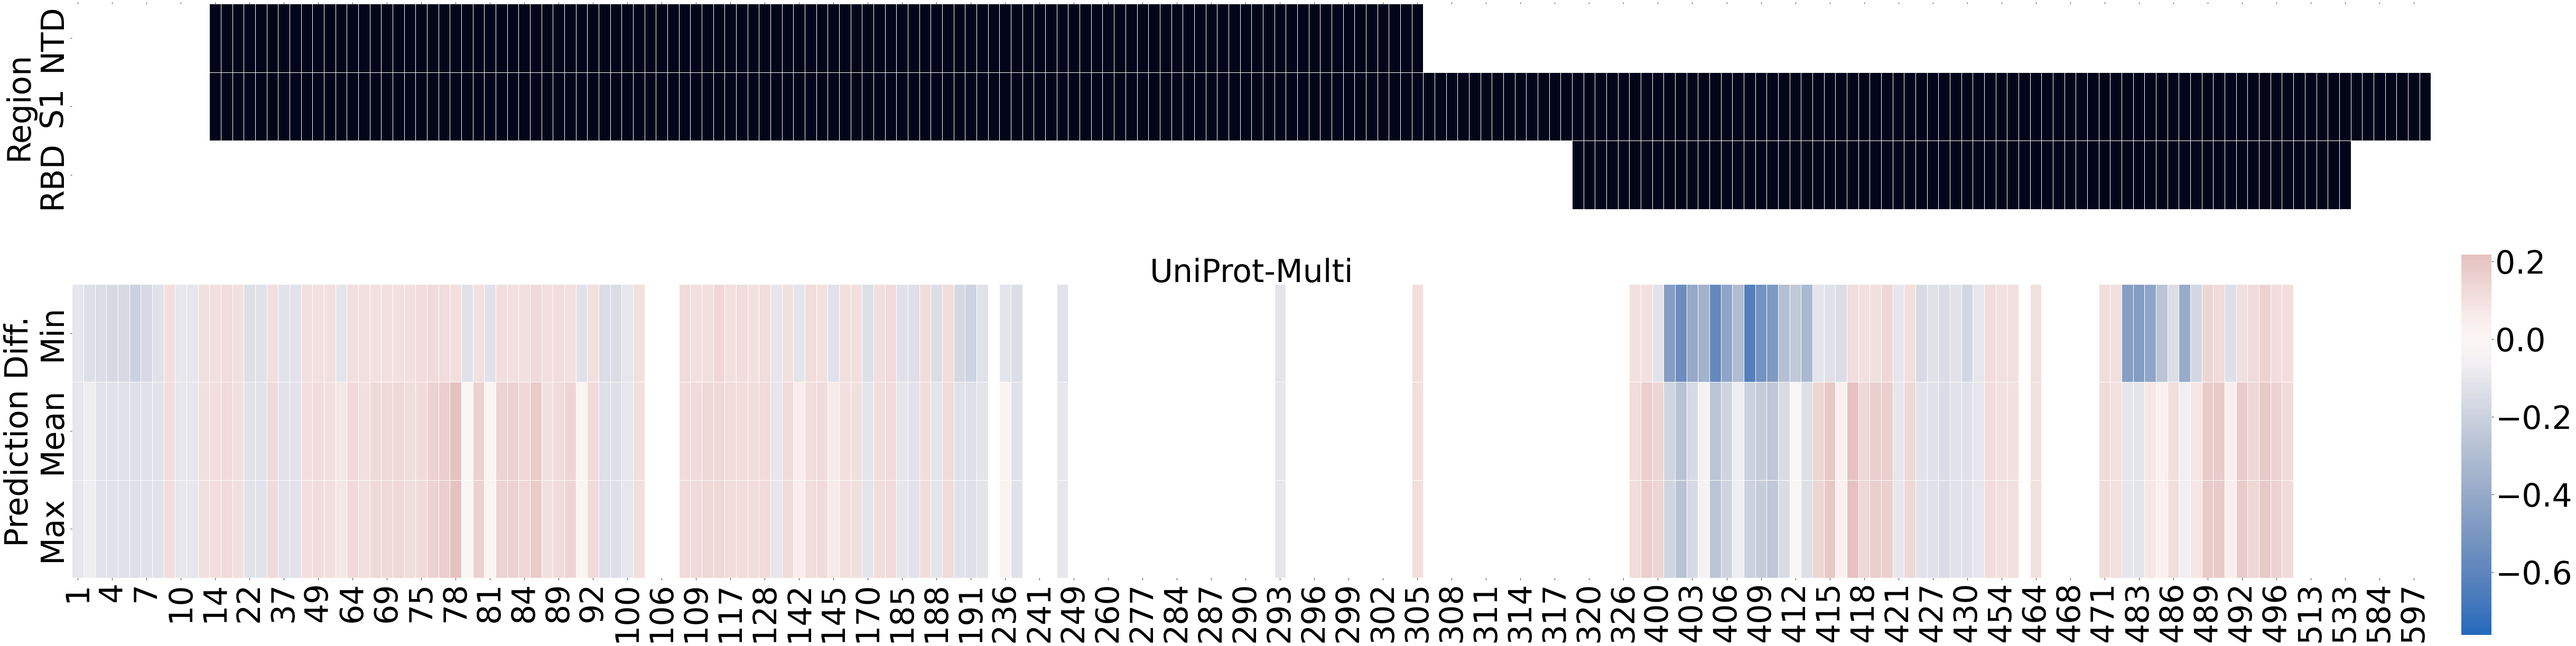

In [35]:
output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/visualization/prelim_exam/sarscov2_s_uniref90_multi_aligned_perturbation_analysis_horizontal.pdf")
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 60
plt.rcParams['ytick.labelsize'] = 60
plt.rcParams.update({'font.size': 60})
fig, ax =plt.subplots(2,1,figsize=(80, 20), sharex=True, gridspec_kw={'height_ratios': [.7, 1, ]})

cbar_ax = fig.add_axes([.91, .05, .01, .5])

sns.heatmap(df_3.T, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=False, linewidth=1)
ax[0].set_ylabel("Region", fontsize=60)
ax[0].set_xlabel("", fontsize=60)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position("top")

df_val = df_2[df_2["experiment"] == "UniRef90-Multi"]
df_val.drop(columns=["experiment"], inplace=True)
df_val = df_val.T
df_val = df_val.reindex(columns=positions)
sns.heatmap(df_val, linewidth=1, ax=ax[1], cmap="vlag", center=0, vmin=vmin, vmax=vmax,
           cbar=True,
           cbar_ax=cbar_ax)

ax[1].set_ylabel("Prediction Diff.")
ax[1].set_xlabel(val, fontsize=60)
ax[1].xaxis.set_label_position("bottom")

# sns.heatmap(df_2_all.T, linewidth=.5, ax=ax[5], cmap="vlag", center=0)
# ax[5].set_ylabel("Prediction Diff.")
# ax[5].set_xlabel("All Models")
# ax[5].xaxis.set_label_position("top")


# sns.heatmap(df_1_pivot.T, linewidth=.5, ax=ax[5], cmap="rocket_r")
# ax[5].set_ylabel("", fontsize=32)
# ax[5].set_xlabel("")

# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(hspace=.3)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.savefig(output_file_path)
plt.show()